# Run GLM-HMM with prior signal as input

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

from numpy.random import default_rng
from scipy.special import logit, expit
from ssm.util import find_permutation

from bfdm.tasks import GlazeTask
from bfdm.glazemodel import GlazeAgent, GlazeModel

In [2]:
rng = default_rng(999)

## Create synthetic data with uncorrelated stimuli

In [3]:
# Number of trials to sample
n_trials = 8000

# Hazard rate of 0.5 reduces Glaze task to Bernoulli process
h_true = 0.5

# Gaussian noise added to stimulus for observation
noise_true = 1.0

task = GlazeTask(hazard_rate=h_true, noise=noise_true, rng=rng)
s, x = task.sample_trials(n_trials)

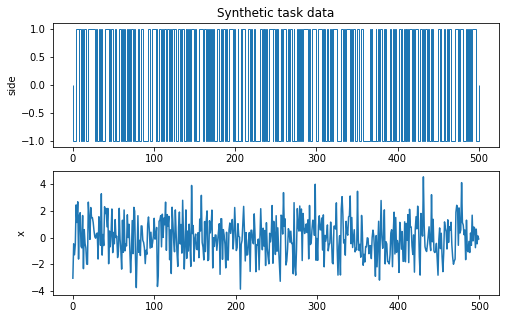

In [4]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(2, 1, figsize=(8, 5))

ax[0].stairs(s[idx])
ax[0].set_ylabel('side')

ax[1].plot(x[idx])
ax[1].set_ylabel('x')

ax[0].set_title('Synthetic task data');

## Run Bayesian filtering agent with underestimated hazard rate on data

In [5]:
# Incorrect value for hazard rate
h_agent = 0.001

# Optimal values for bias and weight
w0_true = 0
w1_true = 2 / (noise_true ** 2)

# Create agent with incorrect hazard rate and otherwise optimal parameters
agent = GlazeAgent(h=h_agent, w_0=w0_true, w_1=w1_true, rng=rng)

# Choice samples and decision function values
y, r = agent.sample(x, return_r=True)

# Compute choice probability from decision function
p = expit(r)

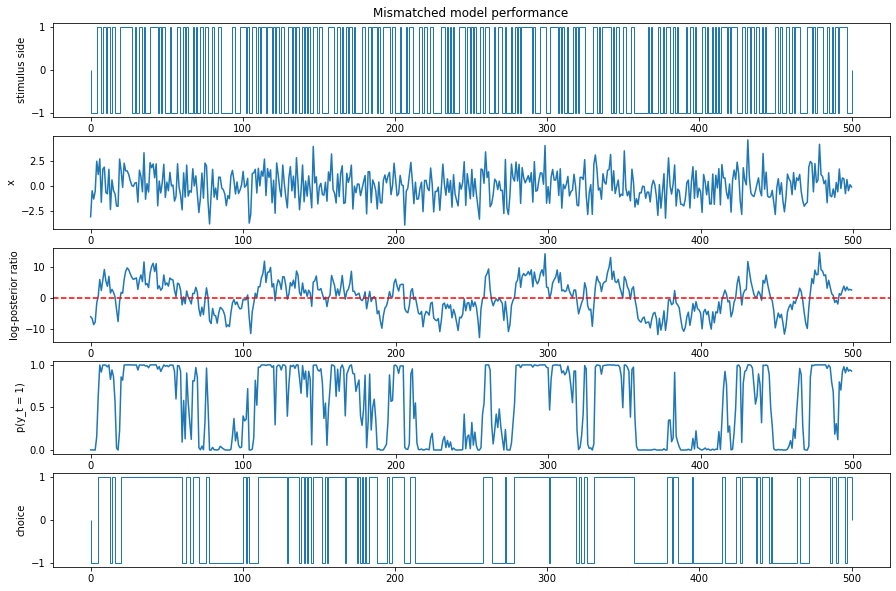

In [6]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(5, 1, figsize=(15, 10))

ax[0].stairs(s[idx])
ax[0].set_ylabel('stimulus side')

ax[1].plot(x[idx])
ax[1].set_ylabel('x')

ax[2].plot(r[idx])
ax[2].axhline(y=0, color='r', linestyle='--')
ax[2].set_ylabel('log-posterior ratio')

ax[3].plot(p[idx])
ax[3].set_ylabel('p(y_t = 1)')

ax[4].stairs(y[idx])
ax[4].set_ylabel('choice')

ax[0].set_title('Mismatched model performance');

### Sanity check: Recover model parameters from behavioral data

In [7]:
# Fit model to preductions from optimal model
model = GlazeModel()
model.fit(x, y)

# Print parameters of fit model
print('hazard rate (h):')
print(f'    model: {model.h:.3f}    agent: {agent.h:.3f}')
print('bias (w_0):')
print(f'    model: {model.w_0:.3f}    agent: {agent.w_0:.3f}')
print('coef (w_1):')
print(f'    model: {model.w_1:.3f}    agent: {agent.w_1:.3f}')

hazard rate (h):
    model: 0.001    agent: 0.001
bias (w_0):
    model: 0.006    agent: 0.000
coef (w_1):
    model: 2.058    agent: 2.000


## Fit GLM-HMM to synthetic behavioral data and prior signal

### Create GLM-HMM and fit to data

In [8]:
# Modify inputs for GLM-HMM (need to add column of ones)
x_mod = np.ones((x.shape[0], 3))
x_mod[:, 0] = x
x_mod[:, 1] = r

# Modify choices for GLM-HMM (y=1 maps to y=0 and y=-1 maps to y=1)
y_mod = np.reshape(y, (-1, 1))
y_mod = (1 - y_mod) / 2
y_mod = y_mod.astype(np.int64)

In [9]:
# Set the parameters of the GLM-HMM
num_states = 4
obs_dim = 1
num_categories = 2
input_dim = 3

# Create GLM-HMM
glm_hmm = ssm.HMM(
    num_states, 
    obs_dim, 
    input_dim, 
    observations="input_driven_obs", 
    observation_kwargs=dict(C=num_categories), 
    transitions="standard"
)

In [10]:
# Number of EM iterations
n_iter = 200

# Fit model
glm_hmm_fit = glm_hmm.fit(
    [y_mod], 
    inputs=[x_mod], 
    method="em", 
    num_iters=n_iter, 
    tolerance=10**-4
)

LP: -1739.8: 100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


In [11]:
glm_hmm_fit[-1]

-1739.8064915000596

### State parameters

In [12]:
params = glm_hmm.observations.params
x_coef_vals = [params[k][0][0] for k in range(num_states)]
r_coef_vals = [params[k][0][1] for k in range(num_states)]
bias_vals = [params[k][0][2] for k in range(num_states)]

for s in range(num_states):
    print(f'state {s}:')
    print(f'  x_coef: {x_coef_vals[s]:.3f}  r_coef: {r_coef_vals[s]:.3f}  bias: {bias_vals[s]:.3f}')

state 0:
  x_coef: -0.464  r_coef: 1.191  bias: 0.045
state 1:
  x_coef: -0.037  r_coef: 1.011  bias: 0.129
state 2:
  x_coef: 0.198  r_coef: 0.948  bias: -0.265
state 3:
  x_coef: 0.912  r_coef: 1.564  bias: 1.093
